## Experimental sensitivity

In [1]:
import sys
sys.path.append("/home/mariacst/exoplanets/exoplanets/python/")
import imp
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population_all
import numpy as np
from lmfit import minimize, Parameters, fit_report 
from scipy.interpolate import griddata
from utils import T_DM, temperature_withDM
from astropy.constants import R_jup, M_sun
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import gaussian_filter1d

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino'], 'size':20})

**TODO : what if i use the same lnL as previous - that is wo the M, r, age part!**

For this part the $\mathcal{L}$ takes the form

\begin{equation}
\ln\mathcal{L}(\gamma, f, M, r, age) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2} -  \frac{1}{2\sigma_M^2}\sum_{i=1}^{N}\frac{\left(M_{i}-M_{obs, i}\right)^2}{M_{obs, i}^2} -  \frac{1}{2\sigma_A^2}\sum_{i=1}^{N}\frac{\left(age_{i}-age_{obs, i}\right)^2}{age_{obs, i}^2} -  \frac{1}{2\sigma_r^2}\sum_{i=1}^{N}\frac{\left(r_{i}-r_{obs, i}\right)^2}{r_{obs, i}^2}
\end{equation}

In [10]:
def lnL(p, rs, Tobs, robs, Mobs, age_obs, points, values, relT, relR, relM, relA, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """
    # free parameters of the fitting  
    f, gamma, r, mass, age = p
    
    ## calculate predictic intrinsic heat flow for mock BDs
    xi       = np.transpose(np.asarray([age, mass]))
    Teff     = griddata(points, values, xi)
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(r, heat_int, f=f, M=mass*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    
    print(np.sum(Teff-T)) # just checking
    # return
    return -0.5*(np.sum(((T-Tobs)/(relT*Tobs))**2.) + np.sum(((r-robs)/(relR*robs))**2.) + 
                 np.sum(((M-Mobs)/(relM*Mobs))**2.) + np.sum(((age-age_obs)/(relA*age_obs))**2.)) 


def TS(gamma, rs, Tobs, robs, Mobs, age_obs, rho0=0.42):
    
    # Find ML estimators
    
    
    # return

I am using the following test statistics:

\begin{equation}
\tilde{q}_\gamma = \begin{cases}
-2\ln\left(\frac{\mathcal{L}(\gamma, \hat{\hat{f}}, \hat{\hat{M}}, \hat{\hat{r}}, \hat{\hat{age}})}{\mathcal{L}(0, \hat{\hat{f(0)}}, \hat{\hat{M(0)}}, \hat{\hat{r(0)}}, \hat{\hat{age(0)}})}\right),\,\, &\hat{\gamma} < 0, \\
-2\ln\left(\frac{\mathcal{L}(\gamma, \hat{\hat{f}}, \hat{\hat{M}}, \hat{\hat{r}}, \hat{\hat{age}})}{\mathcal{L}(\hat{\gamma}, \hat{{f}}, \hat{{M}}, \hat{{r}}, \hat{{age}})}\right),\,\, &0\leq\hat{\gamma} \leq \gamma, \\
0,\,\, &\hat{\gamma}>\gamma 
\end{cases}
\end{equation}

I am going to test the hypothesized value $\gamma$=1. 

First, I am calculating the sampling distribution of $\tilde{q}_\gamma$ that would be obtained considering data samples generated under the background only assumption

In [ ]:
steps = 20



Before trying the above form of the likeihood, which is a movida, lets try first the following

For this part the $\mathcal{L}$ takes the form

\begin{equation}
\ln\mathcal{L}(\gamma) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}(\gamma)+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}

The test statistics takes the following form:

\begin{equation}
\tilde{q}_\gamma = \begin{cases}
-2\ln\left(\frac{\mathcal{L}(\gamma)}{\mathcal{L}(0)}\right),\,\, &\hat{\gamma} < 0, \\
-2\ln\left(\frac{\mathcal{L}(\gamma)}{\mathcal{L}(\hat{\gamma})}\right),\,\, &0\leq\hat{\gamma} \leq \gamma, \\
0,\,\, &\hat{\gamma}>\gamma 
\end{cases}
\end{equation}

In [102]:
def lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """  
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 


def _lnL_minimizer(p, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) - notice that rs is not a free parameter of the analysis!
    """
    # free parameters of the fitting  
    gamma = p["gamma"]
    # Calculate predicted Temperature (DM + intrinsic)
    T        = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    #print(gamma, np.sum(((T-Tobs)/(relT*Tobs))**2.), relT)
    #print("====")
    #print(T, Tobs)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

In [72]:
def TS(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    
    # Find ML estimators
    params = Parameters()
    params.add("gamma", value=1., min=0., max=3.)
    out = minimize(_lnL_minimizer, params, args=(f, rs, Tobs, robs, Mobs, heat_int, relT))
    assert out.success == True, "MLE gamma could not be found!"
    gamma_ML = out.params["gamma"]
    
    if gamma_ML > gamma:
        return 0
    else:
        #print(lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT), lnL(gamma_ML, f, rs, Tobs, robs, Mobs, heat_int, relT))
        return (-2.*lnL(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT)-
                 2*lnL(gamma_ML, f, rs, Tobs, robs, Mobs, heat_int, relT))

**Checking finding MLE for $\gamma$**

In [46]:
# mock observation
nBDs    = 100
relT    = 0.10; relM=0.10; relR=0.10; relA=0.10
f_true  = 0; gamma_true = 1. ; rs_true = 20.; rho0 = 0.42;

robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             f_true, gamma_true, rs_true, 
                                             rho0_true=rho0, 
                                             v=None)

path = "/home/mariacst/exoplanets/exoplanets/data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
xi       = np.transpose(np.asarray([ages, mass]))                            
Teff     = griddata(points, values, xi)                                        
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

params = Parameters()
params.add("gamma", value=1., min=0., max=3.)
out = minimize(lnL_minimizer, params, args=(1., 5., Tobs, robs, mass, heat_int, relT))

In [47]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 100
    # variables        = 1
    chi-square         = 1336.44151
    reduced chi-square = 13.4994092
    Akaike info crit   = 261.259559
    Bayesian info crit = 263.864729
[[Variables]]
    gamma:  3.6438e-13 +/- 0.15440710 (42375852991532.43%) (init = 1)


In [51]:
out.params["gamma"]

<Parameter 'gamma', value=5.227152044540162e-12 +/- 1.37, bounds=[0.0:3.0]>

**Construct the pdf of TS under background only experiments**

In [75]:
steps       = 500
q_gamma_bck = np.ones(steps)

path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

# =============
# Construction under "strength" gamma
gamma = 1.
f     = 1.
rs    = 5.
# =============

nBDs=100; relT=0.10; relM=0.10; relR=0.10; relA=0.10

for i in range(steps):
    robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             0, 1., 1., 
                                             rho0_true=rho0, 
                                             v=None)
    
    xi       = np.transpose(np.asarray([ages, mass]))                            
    Teff     = griddata(points, values, xi)                                        
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    q_gamma_bck[i] = TS(gamma, f, rs, Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)

**Construct the pdf of TS under signal (with "strength" $\gamma$)**

In [77]:
steps       = 500
q_gamma_s   = np.ones(steps)

path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

# =============
# Construction under "strength" gamma
gamma = 1.
f     = 1.
rs    = 5.
# =============

nBDs=100; relT=0.10; relM=0.10; relR=0.10; relA=0.10

for i in range(steps):
    robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                             f, gamma, rs, 
                                             rho0_true=rho0, 
                                             v=None)
    
    xi       = np.transpose(np.asarray([ages, mass]))                            
    Teff     = griddata(points, values, xi)                                        
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    q_gamma_s[i] = TS(gamma, f, rs, Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)

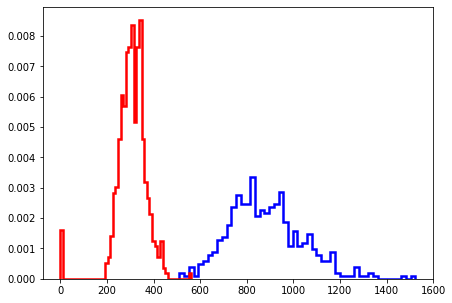

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_, _, _ = ax.hist(q_gamma_bck, bins=50, histtype="step", lw=2.5, color="b", density=True)
_, _, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)

In [93]:
#This is my observation - only background
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                         0, 1., 1., 
                                         rho0_true=rho0, 
                                         v=None)

xi         = np.transpose(np.asarray([ages_R, mass_R]))                            
Teff       = griddata(points, values, xi)                                        
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

In [168]:
# Asumme a given gamma
gamma       = 1.

def UL(gamma, Tobs_R, robs_R, mass_R, heat_int_R, relT_R):
    # Calculate TS_obs
    q_gamma_obs = TS(gamma, 1., 5., Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    
    # Construct pdf of TS for signal + background
    steps       = 200
    q_gamma_s   = np.ones(steps)
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    # Should I add noise in the generation of toy Monte Carlo experiments???
    nBDs=100; relT=0.1; relM=0.1; relR=0.1; relA=0.1
    for i in range(steps):
        robs, Tobs, mass, ages = mock_population_all(nBDs, relT, relM, relR, relA,
                                                 1., gamma, 5., 
                                                 rho0_true=rho0, 
                                                 v=None)    
        xi       = np.transpose(np.asarray([ages, mass]))                            
        Teff     = griddata(points, values, xi)                                        
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        
        q_gamma_s[i] = TS(gamma, 1., 5., Tobs, robs, mass, heat_int, relT, rho0=0.42, v=None)
        
    counts, bins_ed, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)
    
    pos = np.where(bins_ed > q_gamma_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins[1] + bins[0])
    #if np.abs(_p-0.05) < 0.01:
    #    break
    return _p, counts, bins_ed

In [171]:
gamma   = np.linspace(0.5, 1., 15)
p       = []
counts  = [] 
bins_ed = []

for g in gamma:
    _p, _c, _b = UL(g, Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    p.append(_p)
    counts.append(_c)
    bins_ed.append(_b)
    print(g, _p)
    if _p < 0.05:
        break

0.5 1.2339245278179403
0.5357142857142857 0.9124201573208439
0.5714285714285714 0.631829981691125
0.6071428571428571 0.2861507592688307
0.6428571428571428 0.4449823350783776
0.6785714285714286 0.46772999830686246
0.7142857142857143 0.18320843381240806
0.75 0.08857881112053015
0.7857142857142857 0.1350283164837967
0.8214285714285714 0.1092093937267057
0.8571428571428571 0.03624429209945426
0.8928571428571428 0
0.9285714285714286 0


KeyboardInterrupt: 

In [122]:
from scipy.stats import chi2
def half_chi2(q):
    if q==0:
        return (0.5 + chi2.pdf(q, 1))
    else:
        return (chi2.pdf(q, 1))
    
#def half_chi2(q):
#    return (np.heaviside(-q, 0.5) + chi2(q, 1))

q    = np.linspace(0, 8, 100)
f_th = [half_chi2(_q) for _q in q]

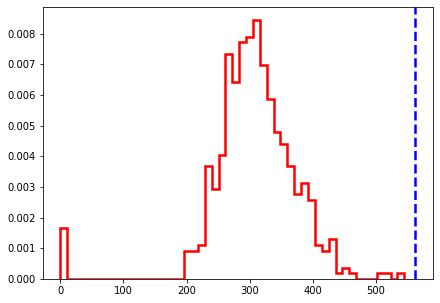

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

#ax.plot(q, f_th, color="k", ls=":", lw=2.5)

ax.axvline(q_gamma_obs, ls="--", color="blue", lw=2.5)
counts, bins_ed, _ = ax.hist(q_gamma_s, bins=50, histtype="step", lw=2.5, color="r", density=True)

**Final tentative**

For this part:

\begin{equation}
\ln\mathcal{L}_{s+b}(\gamma, r_s, f) \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{DM, i}(\gamma, r_s, f)+T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}

and 

\begin{equation}
\ln\mathcal{L}_{b} \propto -\frac{1}{2\sigma_T^2}\sum_{i=1}^{N}\frac{\left(T_{int, i}-T_{obs, i}\right)^2}{T_{obs, i}^2}
\end{equation}


But the test statistics is given by:

\begin{equation}
TS = q_\gamma = 
-2\ln\left(\frac{\mathcal{L}_{s+b}(\gamma, \hat{\hat{f}})}{\mathcal{L}_b}\right)
\end{equation}

In [2]:
def lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) assuming predicted temperature = DM + intrinsic
    """  
    # Calculate predicted temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def lnL_b(Tobs, heat_int, relT):
    """
    Return ln(L) assuming predicted temperature = intrinsic
    """  
    # Calculate predicted intrinsic temperature
    T = temperature(heat_int, R_jup.value).value
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 


def _lnL_sb_minimizer(p, gamma, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return -2ln(L) (assumes Temperature = DM + intrinsic)
    """
    # free parameters of the fitting  
    f = p["f"]
    # Calculate predicted Temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, parameters=[gamma, rs, rho0], v=v)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

In [3]:
def TS(gamma, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Test statistics
    """
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, args=(gamma, rs, Tobs, robs, Mobs, heat_int, relT))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML = out.params["f"].value
    #print("f_ML = ", f_ML)
    # return
    return (-2.*lnL_sb(gamma, f_ML, rs, Tobs, robs, Mobs, heat_int, relT)-2*lnL_b(Tobs, heat_int, relT))

Compute pdf for TS

In [13]:
def p_value(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, steps=200):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs)
    """
    # Find the MLE of f in observation
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, args=(gamma_k, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML_obs = out.params["f"].value
    print("f_ML_obs = ", f_ML_obs)
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    for i in range(steps):
        # Generate mock data sample under the assumption of gamma_k and f_ML_obs
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                                     f_ML_obs, gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))                            
        Teff     = griddata(points, values, xi)                                        
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)   
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = plt.hist(TS_k, bins=50, density=True)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p, counts, bins_ed

*Real* observation - only background

In [14]:
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
    
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R,
                                         0, 1., 1., 
                                         rho0_true=rho0, 
                                         v=None)

xi         = np.transpose(np.asarray([ages_R, mass_R]))                            
Teff       = griddata(points, values, xi)                                        
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

f_ML_obs =  0.4141606863393824
0.0 53.38317331646079
f_ML_obs =  0.28984537187692533
0.10714285714285714 62.792146196792295
f_ML_obs =  0.2017796143561405
0.21428571428571427 55.526051995860584
f_ML_obs =  0.1409915906912168
0.3214285714285714 58.48550321308226
f_ML_obs =  0.0988542276623326


KeyboardInterrupt: 

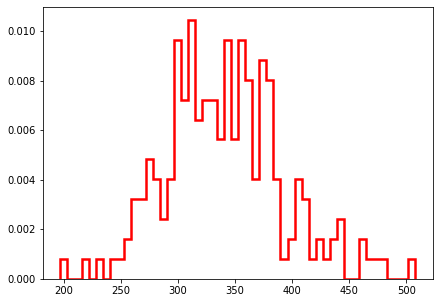

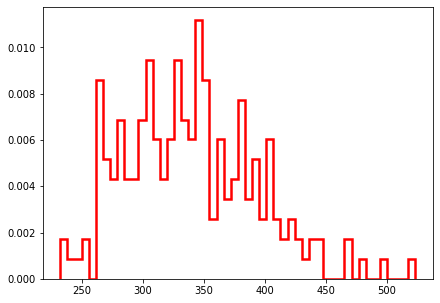

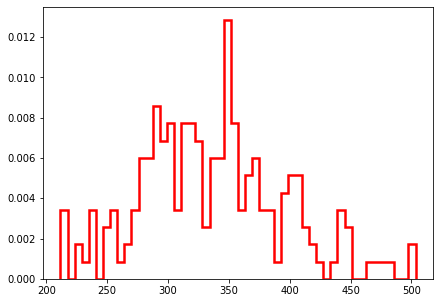

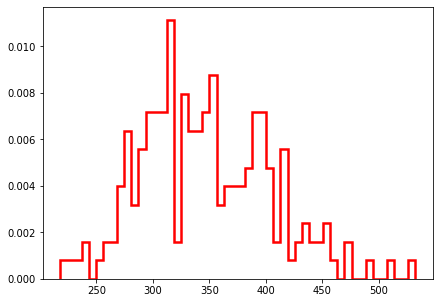

In [15]:
gamma_k = np.linspace(0., 1.5, 15)
rs      = 5.
p       = []
counts  = [] 
bins_ed = []

for g in gamma_k:
    _p, _c, _b = p_value(g, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R)
    p.append(_p)
    counts.append(_c)
    bins_ed.append(_b)
    print(g, _p)
    if _p < 0.05:
        break

The problem is that $\hat{\hat{f}}(\gamma)\sim 0$, therefore $\mathcal{L_{s+b}} --> \mathcal{L_{b}}$ and $\gamma$ is not really influencing the results. We are not able to set an UL! 

Solution: calculate UL for given value of $f$

In [33]:
def lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Return ln(L) assuming predicted temperature = DM + intrinsic
    """  
    # Calculate predicted temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, 
                           parameters=[gamma, rs, rho0], v=v)
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def lnL_b(Tobs, heat_int, relT):
    """
    Return ln(L) assuming predicted temperature = intrinsic
    """  
    # Calculate predicted intrinsic temperature
    T = temperature(heat_int, R_jup.value).value
    # return
    return -0.5*np.sum(((T-Tobs)/(relT*Tobs))**2.) 

def _lnL_sb_minimizer(p, gamma, rs, Tobs, robs, Mobs, heat_int, relT, 
                      rho0=0.42, v=None):
    """
    Return -2ln(L) (assumes Temperature = DM + intrinsic)
    """
    # free parameters of the fitting  
    f = p["f"]
    # Calculate predicted Temperature (DM + intrinsic)
    T = temperature_withDM(robs, heat_int, f=f, M=Mobs*M_sun.value, 
                           parameters=[gamma, rs, rho0], v=v)
    # return
    return ((T-Tobs)/(relT*Tobs))**2.

def TS(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0=0.42, v=None):
    """
    Test statistics
    """
    # return
    return (-2.*lnL_sb(gamma, f, rs, Tobs, robs, Mobs, heat_int, relT, rho0, v)
            -2*lnL_b(Tobs, heat_int, relT))


def p_value(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R, 
            steps=300):
    """
    Return p-value and TS pdf for gamma_k @ (f, rs)
    """
    # Find the MLE of f in observation
    params = Parameters()
    params.add("f", value=0.5, min=0., max=1.)
    out = minimize(_lnL_sb_minimizer, params, 
                   args=(gamma_k, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    assert out.success == True, "MLE gamma could not be found!"
    f_ML_obs = out.params["f"].value
    #print("f_ML_obs = ", f_ML_obs)
    # Compute TS pdf
    TS_k  = np.zeros(steps)
    # Load ATMO2020 model
    path   = "/home/mariacst/exoplanets/exoplanets/data/"
    data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
    points = np.transpose(data[0:2, :])
    values = data[2]
    
    for i in range(steps):
        # Generate mock data sample under the assumption of gamma_k and f_ML_obs
        robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, 
                                         relA_R, f_ML_obs, gamma_k, rs)
        # Predicted intrinsic temperatures
        xi       = np.transpose(np.asarray([ages, Mobs]))
        Teff     = griddata(points, values, xi)
        heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
        # TS
        TS_k[i] = TS(gamma_k, f, rs, Tobs, robs, Mobs, heat_int, relT_R)
    # TS pdf @ gamma_k
    counts, bins_ed, _ = plt.hist(TS_k, bins=50, density=True)
    # observed TS
    q_gamma_k_obs = TS(gamma_k, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R)
    # Compute p-value
    pos = np.where(bins_ed > q_gamma_k_obs)
    _p = 0
    for i in range(len(pos[0])):
        _p += counts[-1-i]*(bins_ed[1] + bins_ed[0])
    # return
    return _p, counts, bins_ed, TS_k, q_gamma_k_obs

In [34]:
# Generate "real" observation assuming only background (no DM)
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
np.random.seed(42) # ========= reproducable results!
robs_R, Tobs_R, mass_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, 
                                     relR_R, relA_R,
                                     0, 1., 1., rho0_true=rho0, v=None)
xi         = np.transpose(np.asarray([ages_R, mass_R]))
Teff       = griddata(points, values, xi)
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

0.0 60.35502009061481


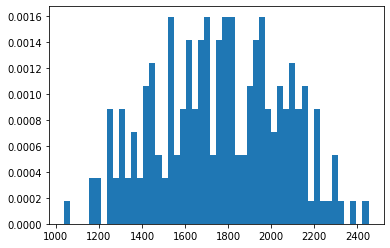

In [39]:
steps    = 200
f        = 1.
rs       = 5.
gamma_k  = np.linspace(0, 1.5, 10) 


for g in gamma_k:
    _p, _c, _b, TS_k, TS_obs = p_value(1.5, f, rs, Tobs_R, robs_R, mass_R, heat_int_R, relT_R, 
                        steps=steps)
    print(g, _p)
    break
    if _p < 0.05:
        gamma_up[i] = g
        p_up[i]     = _p
        print(rs[i], g, _p)
        break

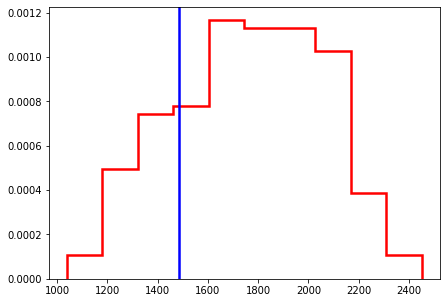

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
_, _, _ = ax.hist(TS_k, color="r", lw=2.5, histtype="step", density=True)
ax.axvline(TS_obs, color="blue", ls="-", lw=2.5)

# Current upper limits

In [2]:
rs = [5., 20.]
gamma_UL_asi = [0.4821, 0.8897]
gamma_UL_5   = np.genfromtxt("../python/data_UL/UL_f1.0_rs5.0_steps200.dat")
gamma_UL_20  = np.genfromtxt("../python/data_UL/UL_f1.0_rs20.0_steps200.dat")

Text(0.5, 0, '$\\gamma$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


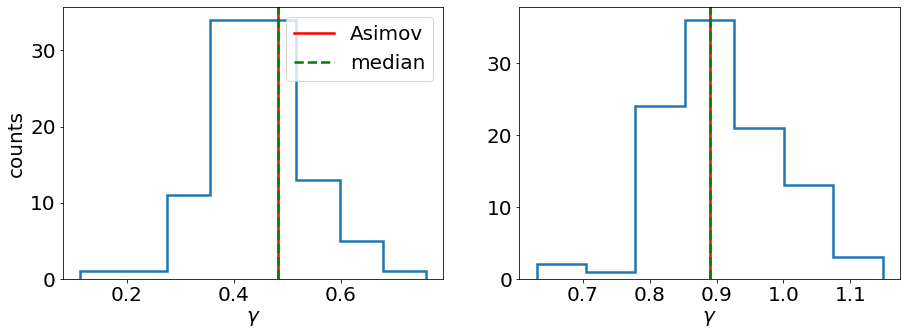

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(gamma_UL_5, bins=8, histtype="step", lw=2.5);
ax[0].axvline(gamma_UL_asi[0], color="red", lw=2.5, label="Asimov")
ax[0].axvline(np.median(gamma_UL_5), color="green", ls="--", lw=2.5, label="median")
ax[0].legend()
ax[0].set_ylabel("counts")
ax[0].set_xlabel(r"$\gamma$")

ax[1].hist(gamma_UL_20, bins=7, histtype="step", lw=2.5);
ax[1].axvline(gamma_UL_asi[1], color="red", lw=2.5)
ax[1].axvline(np.median(gamma_UL_20), color="green", ls="--", lw=2.5)
ax[1].set_xlabel(r"$\gamma$")

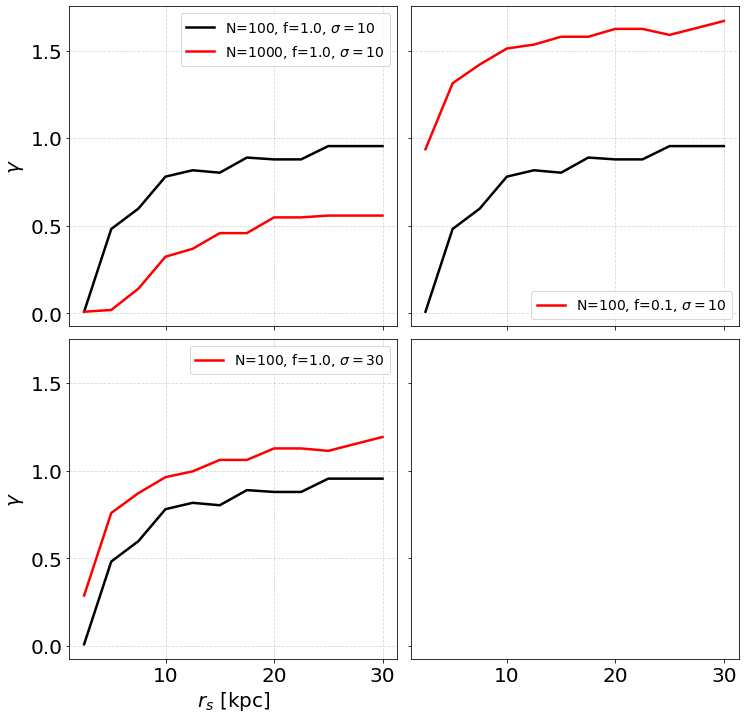

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

sigma = 0.1
nBDs  = [100, 1000]
f     = [0.1, 1]
color = ["blue", "orange"]
ls    = ["-", "--"]

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" %(100, 1., 0.1), unpack=True)
ax[0, 0].plot(data[0], data[1], color="k", lw=2.5, ls="-", 
              label=r"N=%i, f=%.1f, $\sigma=$%i" %(100, 1, 10))
ax[0, 1].plot(data[0], data[1], color="k", lw=2.5, ls="-")
ax[1, 0].plot(data[0], data[1], color="k", lw=2.5, ls="-")

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" %(1000, 1., 0.1), unpack=True)
ax[0, 0].plot(data[0], data[1], color="r", lw=2.5, ls="-", 
              label=r"N=%i, f=%.1f, $\sigma=$%i" %(1000, 1, 10))

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" %(100, 0.1, 0.1), unpack=True)
ax[0, 1].plot(data[0], data[1], color="r", lw=2.5, ls="-", 
              label=r"N=%i, f=%.1f, $\sigma=$%i" %(100, 0.1, 10))

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" %(100, 1, 0.3), unpack=True)
ax[1, 0].plot(data[0], data[1], color="r", lw=2.5, ls="-", 
              label=r"N=%i, f=%.1f, $\sigma=$%i" %(100, 1, 30))


ax[0, 0].legend(fontsize=14); ax[0, 1].legend(fontsize=14); ax[1, 0].legend(fontsize=14)
ax[0, 0].set_ylabel(r"$\gamma$"); ax[1, 0].set_xlabel("$r_s$ [kpc]"); ax[1, 0].set_ylabel(r"$\gamma$");
ax[0, 0].grid(ls="--", alpha=0.5); ax[0, 1].grid(ls="--", alpha=0.5); ax[1, 0].grid(ls="--", alpha=0.5)

plt.subplots_adjust(hspace=0.04, wspace=0.04)


Text(0.5, 0, '$r_s$ [kpc]')

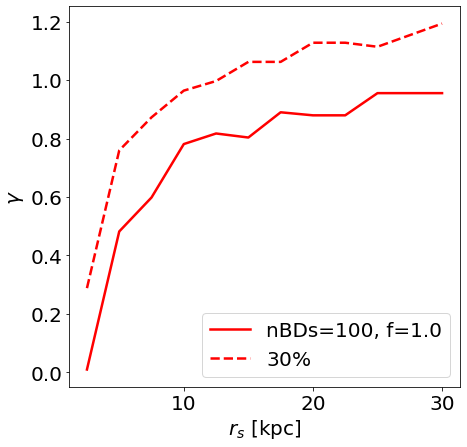

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sigma = 0.1
nBDs  = [100]
f     = [1]
color = ["blue", "orange"]
ls    = ["-", "--"]

for i in range(len(nBDs)):
    for j in range(len(f)):
        data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                                 %(nBDs[i], f[j], 0.1), unpack=True)
        ax.plot(data[0], data[1], color="red", lw=2.5, ls=ls[j], label=r"nBDs=%i, f=%.1f" 
                %(nBDs[i], f[j]))
        data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                                 %(nBDs[i], f[j], 0.3), unpack=True)
        ax.plot(data[0], data[1], color="red", lw=2.5, ls="--", label=r"30$\%$")

ax.legend()
ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")

Text(0.5, 0, '$r_s$ [kpc]')

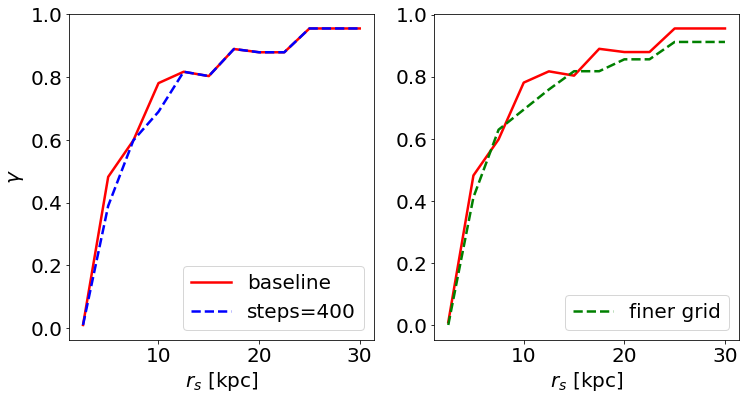

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sigma = 0.1
nBDs  = 100
f     = 1

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                     %(nBDs, f, sigma), unpack=True)
ax[0].plot(data[0], data[1], color="red", lw=2.5, ls="-", label="baseline")
ax[1].plot(data[0], data[1], color="red", lw=2.5, ls="-")

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps%i_sigma%.1f_Asimov.dat" 
                     %(nBDs, f, 400, sigma), unpack=True)
ax[0].plot(data[0], data[1], color="blue", lw=2.5, ls="--", label="steps=400")

data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov_finer.dat" 
                     %(nBDs, f, sigma), unpack=True)
ax[1].plot(data[0], data[1], color="green", lw=2.5, ls="--", label="finer grid")

ax[0].legend(); ax[1].legend()
ax[0].set_ylabel(r"$\gamma$"); ax[0].set_xlabel("$r_s$ [kpc]"); ax[1].set_xlabel("$r_s$ [kpc]")

Text(0.5, 0, '$r_s$ [kpc]')

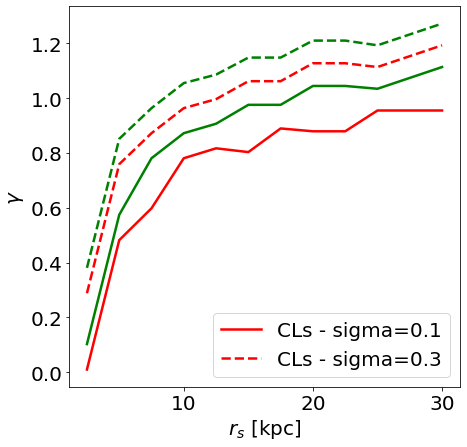

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sigma = [0.1, 0.3]
nBDs  = 100
f     = 1
color = ["blue", "orange"]
ls    = ["-", "--"]

for j in range(len(sigma)):
    data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                             %(nBDs, f, sigma[j]), unpack=True)
    ax.plot(data[0], data[1], color="red", lw=2.5, ls=ls[j], label="CLs - sigma=%.1f" %sigma[j])
    try:
        data = np.genfromtxt("../python/data_UL/UL_nBDs%i_f%.1f_steps200_Asimov_sigma%.1f_CLsb.dat" 
                             %(nBDs, f, sigma[j]), unpack=True)
        ax.plot(data[0], data[1], color="green", lw=2.5, ls=ls[j])
    except:
        continue

ax.legend()
ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")

In [3]:
def plot_UL(ax, ex, nBDs, sigma, f, color="red", ls="-", path="../python/data_UL/"):
    data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
    ax.plot(data[0], data[1], color=color, lw=2.5, ls=ls, label="nBDs=%i, sigma=%.1f, f=%.1f" 
            %(nBDs, sigma, f))
    # return
    return

In [3]:
def FigSetup(lw=2.5,lfs=40,tfs=25,tickdir='out',
             Grid=False,Shape='Square',mathpazo=False,
             TopAndRightTicks=False):

        plt.rcParams['axes.linewidth'] = lw
        plt.rc('text', usetex=False)
        plt.rc('font', family='serif',size=tfs)

        if mathpazo:
            mpl.rcParams['text.latex.preamble'] = [r'\usepackage{mathpazo}']

        if Shape=='Wide':
            fig = plt.figure(figsize=(16.5,5))
        elif Shape=='Rectangular':
            fig = plt.figure(figsize=(16.5,11))
        elif Shape=="Square":
            fig = plt.figure(figsize=(8,8))

        ax = fig.add_subplot(111)

        ax.tick_params(which='major',direction=tickdir,width=2.5,length=13,right=TopAndRightTicks,top=TopAndRightTicks,pad=7)
        ax.tick_params(which='minor',direction=tickdir,width=1,length=10,right=TopAndRightTicks,top=TopAndRightTicks)

        ax.set_xlim(2.5, 30); ax.set_ylim(0.1, 2.)
        
        #locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=50)
        #locmin = mpl.ticker.LogLocator(base=10.0, subs=arange(2, 10)*.1,numticks=100)
        #ax.xaxis.set_major_locator(locmaj)
        #ax.xaxis.set_minor_locator(locmin)
        #ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

        #locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
        #locmin = mpl.ticker.LogLocator(base=10.0, subs=arange(2, 10)*.1,numticks=100)
        #ax.yaxis.set_major_locator(locmaj)
        #ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

        if Shape=='Rectangular':
            plt.xticks(rotation=20)

        if Grid:
            ax.grid(zorder=0)

        return fig, ax

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


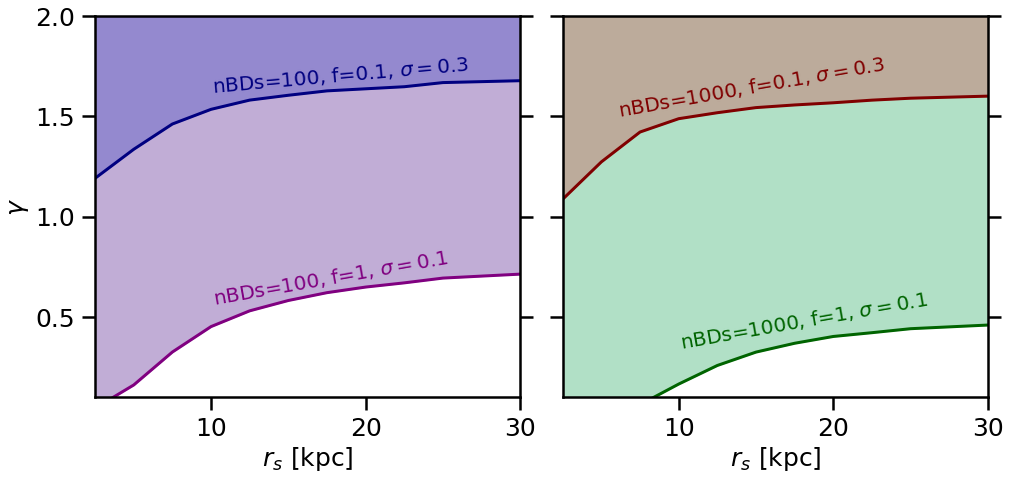

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=25)

ax[0].tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)
ax[1].tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)


path="../python/data_UL/"

line_col = 'navy'
col = 'royalblue'

zo = 0.01; smooth=0.8; small_fs=20

ex="fixedT10v100"; nBDs=100; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10,1.62, "nBDs=%i, f=0.1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=5)

line_col = 'purple'
col = 'rebeccapurple'

ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10,0.56, "nBDs=%i, f=1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)

ax[0].set_ylabel(r"$\gamma$"); ax[0].set_xlabel("$r_s$ [kpc]")
ax[0].set_ylim(0.1, 2.); ax[0].set_xlim(2.5, 30.)

plt.subplots_adjust(wspace=0.1)


col = 'mediumseagreen'
line_col = 'darkgreen'

ex="fixedT10v100"; nBDs=1000; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(10, 0.34, "nBDs=%i, f=1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)

col = "indianred"#'orange'
line_col = "maroon"#'darkorange'

ex="fixedT10v100"; nBDs=1000; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(6, 1.5, "nBDs=%i, f=0.1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)
ax[1].set_xlim(2.5, 30.); ax[1].set_xlabel("$r_s$ [kpc]")

fig.savefig("sensitivity_fixedT10v100.png", bbox_inches="tight")

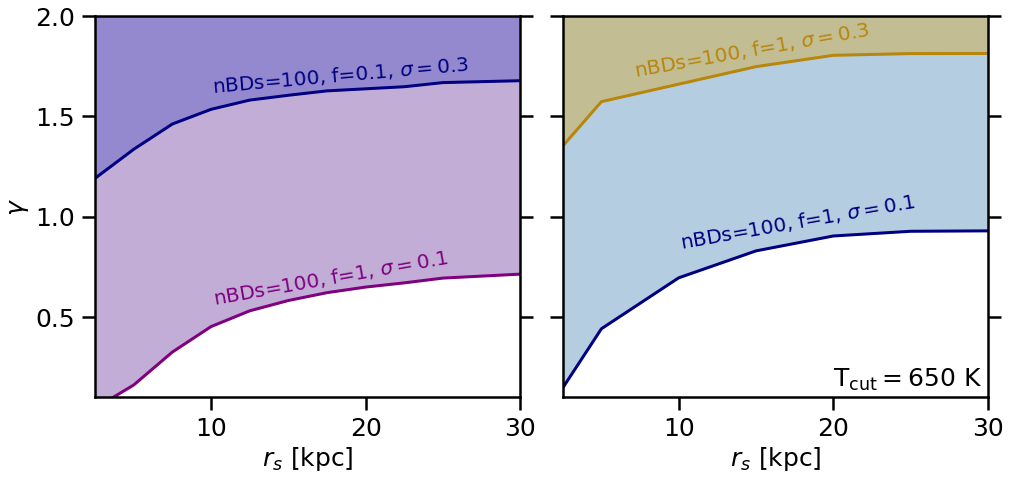

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=25)

ax[0].tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)
ax[1].tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)


path="../python/data_UL/"

line_col = 'navy'
col = 'royalblue'

zo = 0.01; smooth=0.8; small_fs=20

ex="fixedT10v100"; nBDs=100; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10,1.62, "nBDs=%i, f=0.1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=5)

line_col = 'purple'
col = 'rebeccapurple'

ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10,0.56, "nBDs=%i, f=1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)

ax[0].set_ylabel(r"$\gamma$"); ax[0].set_xlabel("$r_s$ [kpc]")
ax[0].set_ylim(0.1, 2.); ax[0].set_xlim(2.5, 30.)

plt.subplots_adjust(wspace=0.1)


col = 'steelblue'
line_col = 'navy'

ex="fixedT10v100Tcut650"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(10, 0.84, "nBDs=%i, f=1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)
ax[1].text(20, 0.15, r"T$_{\rm cut}=650$ K")

col = 'goldenrod'
line_col = 'darkgoldenrod'

ex="fixedT10v100Tcut650"; nBDs=100; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(7., 1.7, "nBDs=%i, f=1, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)

ax[1].set_xlim(2.5, 30.); ax[1].set_xlabel("$r_s$ [kpc]")

fig.savefig("sensitivity_fixedT10v100_vs_fixedT10v100Tcut650.pdf", bbox_inches="tight")

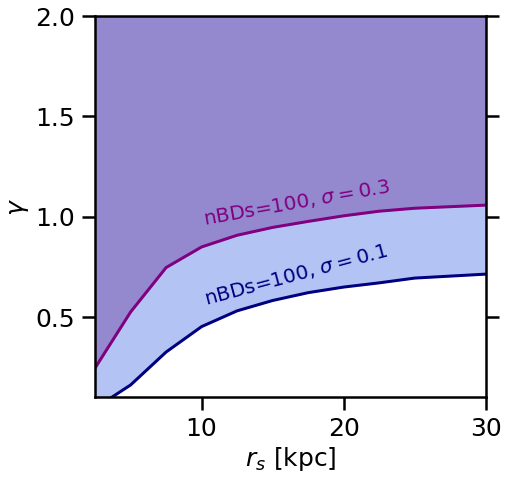

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), sharey=True)

plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=25)


ax.tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)


path="../python/data_UL/"

line_col = 'navy'
col = 'royalblue'

zo = 0.01; smooth=0.8; small_fs=20

ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax.fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax.plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax.text(10,0.56, "nBDs=%i, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=15)
ax.set_ylim(0.1, 2.); ax.set_xlim(2.5, 30.)
ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")


plot="True"
if plot=="True":
    
        
    line_col = 'purple'
    col = 'rebeccapurple'
    
    ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.3
    data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                             %(nBDs, f, sigma), unpack=True)
    ax.fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
    ax.plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
    ax.text(10,0.96, "nBDs=%i, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)
    
        
    col = 'goldenrod'
    line_col = 'darkgoldenrod'
    
    ex="fixedT10v100"; nBDs=1000; f=1.; sigma=0.1
    data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                             %(nBDs, f, sigma), unpack=True)
    ax.fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
    ax.plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
    print(data[0])
    ax.text(9., 0.3, "nBDs=%i, $\sigma=%.1f$" %(nBDs, sigma),color=line_col,fontsize=small_fs,rotation=10)

fig.savefig("sensitivity_2.pdf", bbox_inches="tight")

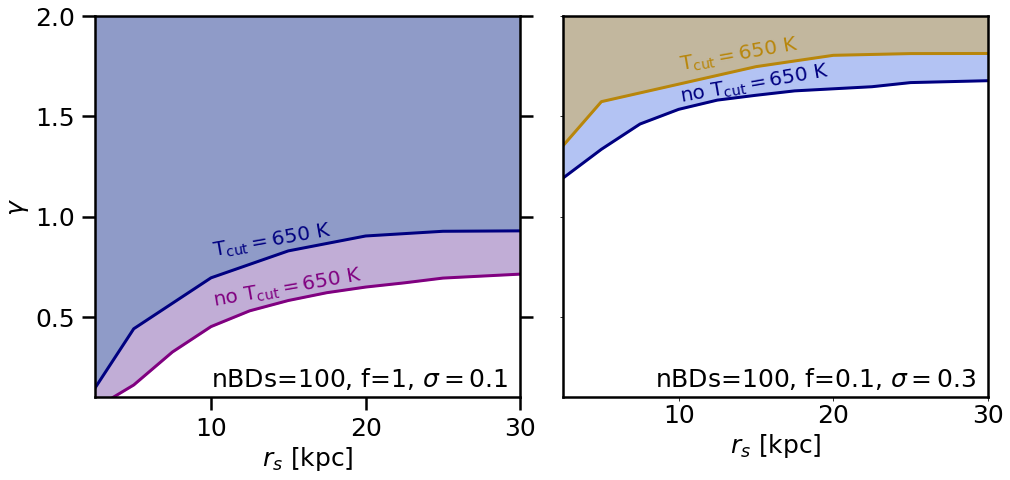

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=25)

ax[0].tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)

path="../python/data_UL/"

line_col = 'purple'
col = 'rebeccapurple'

ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10, 0.55, r"no T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)

col = 'steelblue'
line_col = 'navy'

ex="fixedT10v100Tcut650"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                       %(nBDs, f, sigma), unpack=True)
ax[0].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[0].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[0].text(10, 0.80, r"T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)
ax[0].text(10, 0.15, "nBDs=%i, f=1, $\sigma=%.1f$"%(nBDs, sigma))

ax[0].set_ylabel(r"$\gamma$"); ax[0].set_xlabel("$r_s$ [kpc]")
ax[0].set_xlim(2.5, 30.); ax[0].set_ylim(0.1, 2.);



line_col = 'navy'
col = 'royalblue'

ex="fixedT10v100"; nBDs=100; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(10, 1.57, r"no T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)

col = 'goldenrod'
line_col = 'darkgoldenrod'

ex="fixedT10v100Tcut650"; nBDs=100; f=0.1; sigma=0.3
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                       %(nBDs, f, sigma), unpack=True)
ax[1].fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax[1].plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax[1].text(10, 1.73, r"T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)
ax[1].text(8.5, 0.15, "nBDs=%i, f=0.1, $\sigma=%.1f$"%(nBDs, sigma))

ax[1].set_xlabel("$r_s$ [kpc]")
ax[1].set_xlim(2.5, 30.); ax[1].set_ylim(0.1, 2.);



plt.subplots_adjust(wspace=0.1)


fig.savefig("sensitivity_fixedT10v100_vs_fixedT10v100Tcut650_nBDs100f1.0sigma0.1.pdf", bbox_inches="tight")


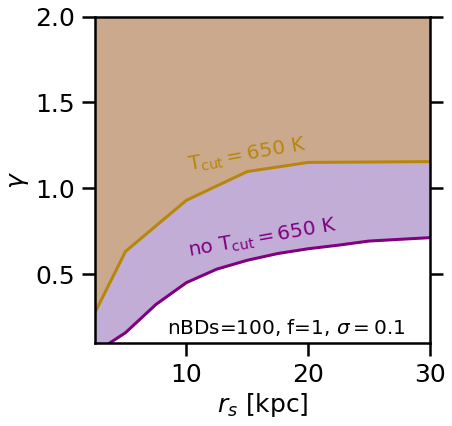

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif',size=25)

ax.tick_params(which='major',direction="out",width=2.5,length=13,right=True,top=False,pad=7)

path="../python/data_UL/"

line_col = 'purple'
col = 'rebeccapurple'

smooth=0.8

ex="fixedT10v100"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                         %(nBDs, f, sigma), unpack=True)
ax.fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax.plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3.)
ax.text(10, 0.6, r"no T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)


col = 'goldenrod'
line_col = 'darkgoldenrod'

ex="fixedT10v100Tcut650_nocutTwn"; nBDs=100; f=1.; sigma=0.1
data = np.genfromtxt(path + "UL_" + ex + "_nBDs%i_f%.1f_steps200_sigma%.1f_Asimov.dat" 
                       %(nBDs, f, sigma), unpack=True)
ax.fill_between(data[0], gaussian_filter1d(data[1], sigma=smooth), y2=2.,color=col,alpha=0.4,zorder=zo)
ax.plot(data[0], gaussian_filter1d(data[1], sigma=smooth), color=line_col, lw=3., label="nocutTwn")
ax.text(10, 1.1, r"T$_{\rm cut}=650$ K", color=line_col,fontsize=small_fs,rotation=10)

ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")
ax.set_xlim(2., 30.); ax.set_ylim(0.1, 2.); 

ax.text(8.4, 0.15, "nBDs=%i, f=1, $\sigma=%.1f$"%(nBDs, sigma), fontsize=20)

ax.set_xlim(2.5, 30.); ax.set_ylim(0.1, 2.);

fig.savefig("sensitivity_fixedT10v100_vs_fixedT10v100Tcut650_nBDs100f1.0sigma0.1.png", bbox_inches="tight")

Text(0.5, 0, '$r_s$ [kpc]')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


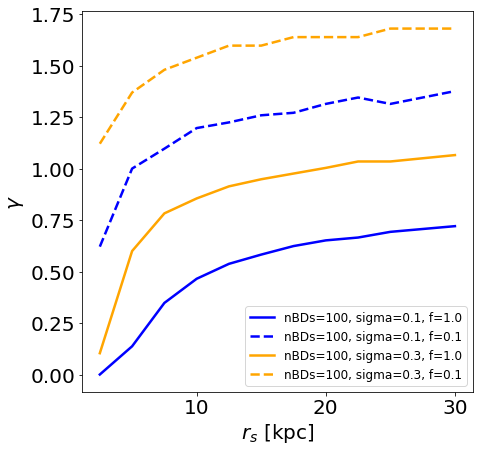

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_UL(ax, "fixedT10v100", 100, 0.1, 1., "blue")
plot_UL(ax, "fixedT10v100", 100, 0.1, 0.1, "blue", "--")
plot_UL(ax, "fixedT10v100", 100, 0.3, 1., "orange")
plot_UL(ax, "fixedT10v100", 100, 0.3, 0.1, "orange", "--")

ax.legend(fontsize=12)
ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")

Text(0.5, 0, '$r_s$ [kpc]')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


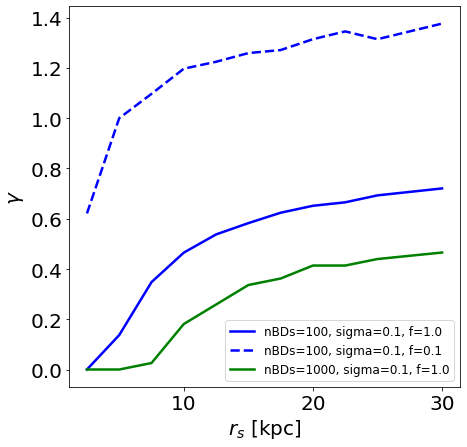

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

plot_UL(ax, "fixedT10v100", 100, 0.1, 1., "blue")
plot_UL(ax, "fixedT10v100", 100, 0.1, 0.1, "blue", "--")
plot_UL(ax, "fixedT10v100", 1000, 0.1, 1., "green")

ax.legend(fontsize=12)
ax.set_ylabel(r"$\gamma$"); ax.set_xlabel("$r_s$ [kpc]")

### Investigate Tcut results

In [77]:
from experimental_sensitivity_CL_Asimov_Tcut import sigma_Tmodel2
from scipy.stats import percentileofscore

conv_Msun_to_kg = 1.98841e+30

def lnL_sb(gamma, f, rs, robs, sigma_robs, Mobs, sigma_Mobs, Aobs, sigma_Aobs,  
           Tobs, sigma_Tobs, Tint, dervTint_M, dervTint_A,                      
           v=None, R=R_jup.value, Rsun=8.178, rho0=0.42, epsilon=1.):           
    """                                                                         
    Return ln(L) assuming predicted temperature = DM + intrinsic                
    """                                                                         
    # Calculate predicted temperature (DM + intrinsic)                          
    Tmodel = temperature_withDM(robs, Tint, M=Mobs*conv_Msun_to_kg, f=f,        
                           p=[gamma, rs, rho0], v=v)                            
                                                                                
    _sigma_Tmodel2 = sigma_Tmodel2(robs, Mobs, Aobs, sigma_robs, sigma_Mobs,    
                                   sigma_Aobs, Tint, dervTint_M, dervTint_A,    
                                   f, [gamma, rs, rho0], v=v, R=R, Rsun=Rsun,   
                                   epsilon=epsilon)                             
    # return                                                                    
    return -0.5*np.sum((Tmodel-Tobs)**2/(sigma_Tobs**2 + _sigma_Tmodel2))       
                                                                                
                                                                                
def lnL_b(sigma_Mobs, sigma_Aobs, Tobs, sigma_Tobs, Tint, dervTint_M,           
          dervTint_A):                                                          
    """                                                                         
    Return ln(L) assuming predicted temperature = intrinsic                     
    """                                                                         
                                                                                
    sigma_Tint2 = (np.power(dervTint_A*sigma_Aobs, 2) +                         
                   np.power(dervTint_M*sigma_Mobs, 2))                          
                                                                                
    # return                                                                    
    return -0.5*np.sum((Tint-Tobs)**2/(sigma_Tobs**2 + sigma_Tint2))  


def TS(gamma, f, rs, robs, sigma_robs, Mobs, sigma_Mobs, Aobs, sigma_Aobs,      
       Tobs, sigma_Tobs, Tint, dervTint_M, dervTint_A,                          
       v=None, R=R_jup.value, Rsun=8.178, rho0=0.42, epsilon=1.):               
    """                                                                         
    Test statistics                                                             
    """                                                                         
    # return                                                                    
    return (-2.*lnL_sb(gamma, f, rs, robs, sigma_robs, Mobs, sigma_Mobs,        
                       Aobs, sigma_Aobs, Tobs, sigma_Tobs, Tint, dervTint_M,    
                       dervTint_A, v=v, R=R, Rsun=Rsun, rho0=rho0,              
                       epsilon=epsilon)                                         
            +2*lnL_b(sigma_Mobs, sigma_Aobs, Tobs, sigma_Tobs, Tint,            
                     dervTint_M, dervTint_A)                                    
            )


def p_value_sb(gamma_k, f, rs, nBDs, relT, relM, relR, relA, points, values,    
               TS_obs, steps=300, Tmin=0., v=None, ex="fixedT10v100Tcut650"):                             
    """                                                                         
    Return p-value for gamma_k @ (f, rs) under s+b hypothesis                   
    """                                                                         
    # Compute TS pdf                                                            
    TS_k = np.zeros(steps)                                                      
    for i in range(steps):                                                      
        # Generate experiments under s+b hypothesis                             
        np.random.seed(i)                                                       
        (robs, sigmarobs, Tobs, sigmaTobs, Mobs, sigmaMobs, Aobs,               
        sigmaAobs) = mock_population_all(nBDs, relT, relM, relR, relA,          
                                           f, gamma_k, rs, Tmin=Tmin,v=v)       
        # Predicted intrinsic temperatures                                         
        xi       = np.transpose(np.asarray([Aobs, Mobs]))                       
        Teff     = griddata(points, values, xi)                                 
        # Load derivatives Tint wrt Age and Mass                                
        data = np.genfromtxt(path + "derivativeTint_" + ex + "_N%i_sigma%.1f_v%i.dat"
                     %(nBDs, relM, i), unpack=True)                           
        dervTint_A = data[0]                                                    
        dervTint_M = data[1]                         
        # TS                                                                    
        TS_k[i] = TS(gamma_k, f, rs, robs, sigmarobs, Mobs, sigmaMobs, Aobs,    
                     sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M, dervTint_A,  
                     v=v)                                                                                                 
    # return                                                                    
    return (100-percentileofscore(TS_k, TS_obs, kind="strict"), TS_k)


def p_value_b(gamma_k, f, rs, nBDs, relT, relM, relR, relA, points, values,     
              TS_obs, steps=300, Tmin=0., v=None, ex="fixedT10v100Tcut650"):    
    """                                                                         
    Return p-value for gamma_k @ (f, rs) under b hypothesis                     
    """                                                                         
    # Compute TS pdf                                                            
    TS_k = np.zeros(steps)                                                      
    path = "/home/mariacst/exoplanets/exoplanets/python/data_der/"              
    for i in range(steps):                                                      
        # Generate experiments under s+b hypothesis                             
        np.random.seed(i)                                                     
        (robs, sigmarobs, Tobs, sigmaTobs, Mobs, sigmaMobs, Aobs,               
        sigmaAobs) = mock_population_all(nBDs, relT, relM, relR, relA,          
                                           0., 1., 1., Tmin=Tmin)               
                                                                                
        # Predicted intrinsic temperatures                                      
        xi       = np.transpose(np.asarray([Aobs, Mobs]))                       
        Teff     = griddata(points, values, xi)                                 
        # Load derivatives Tint wrt Age and Mass                                
        data = np.genfromtxt(path + "derivativeTint_" + ex + "_N%i_sigma%.1f_v%i.dat"
                     %(nBDs, relM, i), unpack=True)                           
        dervTint_A = data[0]                                                    
        dervTint_M = data[1]                                                    
        # TS                                                                    
        TS_k[i] = TS(gamma_k, f, rs, robs, sigmarobs, Mobs, sigmaMobs, Aobs,    
                     sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M, dervTint_A, v=v)                                               
    # return                                                                    
    return (100-percentileofscore(TS_k, TS_obs, kind="strict"), TS_k)

In [94]:
f         = 0.1                                                 
nBDs      = 100                                                                
sigma     = 0.3                                                                
                                              
steps     = 200 # Need to vary                                                 
                                                                               
relT = 0.1;                                                                    
ex   = "fixedT10v100Tcut650"                                                   
v    = 100. # km/s                                                             
Tcut = 650. # KI                                                               
# Load ATMO2020 model                                                          
path     = "/home/mariacst/exoplanets/exoplanets/data/"                          
data     = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)         
points   = np.transpose(data[0:2, :])                                            
values   = data[2]                                                             
                                                
path = "/home/mariacst/exoplanets/exoplanets/python/data_der/"                 
#path = "/home/mariacst/exoplanets/running/v100_N1e5/data_der/"                
# Generate real observation                                                    
seed      = 250                                                                
np.random.seed(seed)                                                           
(robs, sigmarobs, Tobs, sigmaTobs, Mobs,                                      
    sigmaMobs, Aobs, sigmaAobs) = mock_population_all_Asimov(nBDs, relT,              
                                  sigma, sigma, sigma, 0., 1., 1.,             
                                  Tmin=Tcut, v=v) 

xi   = np.transpose(np.asarray([Aobs, Mobs]))                               
Teff = griddata(points, values, xi)                                         

In [96]:
import imp
import derivatives
imp.reload(derivatives)
from derivatives import derivativeTint_wrt_A, derivativeTint_wrt_M
# Calculate derivatives Tint wrt Age and Mass                               
dervTint_A = np.ones(nBDs)                                                  
dervTint_M = np.ones(nBDs)                                                  
size       = 7000                                                           
h          = 0.001                                                          
from derivatives import derivativeTint_wrt_A, derivativeTint_wrt_M 
for i in range(nBDs):                                                       
    dervTint_A[i] = derivativeTint_wrt_A(Mobs[i], Aobs[i], points, values,  
                                     size=size, h=h)                        
    dervTint_M[i] = derivativeTint_wrt_M(Mobs[i], Aobs[i], points, values,  
                                     size=size, h=h)  

In [97]:
import imp
import derivatives
imp.reload(derivatives)
from derivatives import derivativeTint_wrt_A, derivativeTint_wrt_M
# Calculate derivatives Tint wrt Age and Mass                                                                               
dervTint_M_9000 = np.ones(nBDs)                                                  
size       = 9000                                                           
h          = 0.001                                                          
from derivatives import derivativeTint_wrt_A, derivativeTint_wrt_M 
for i in range(nBDs):                                                                             
    dervTint_M_9000[i] = derivativeTint_wrt_M(Mobs[i], Aobs[i], points, values,  
                                     size=size, h=h)  

In [85]:
gamma_k = 1.79286; rs_k=15.

TS_obs = TS(gamma_k, f, rs_k, robs, sigmarobs, Mobs, sigmaMobs, Aobs,           
                    sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M,               
                    dervTint_A, v=v)

print (TS_obs)

-2.5255541473868988


In [82]:
gamma_k = 1.79286; rs_k=15.

TS_obs = TS(gamma_k, f, rs_k, robs, sigmarobs, Mobs, sigmaMobs, Aobs,           
                    sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M,               
                    dervTint_A, v=v)

print (TS_obs)

-0.32759851604092205


In [51]:
_, TS_bck = p_value_b(gamma_k, f, rs_k, nBDs, relT, sigma, sigma, sigma,                
                      points, values, TS_obs, steps=steps, Tmin=Tcut, v=v)

In [57]:
path    = "../python/"
TS_k_sb = np.genfromtxt(path + "TS_sb_fixedT10v100Tcut650_nBDs100_f0.1_steps200_sigma0.3_gamma%.5frs%.1f.dat"%(gamma_k, rs_k), unpack="True")

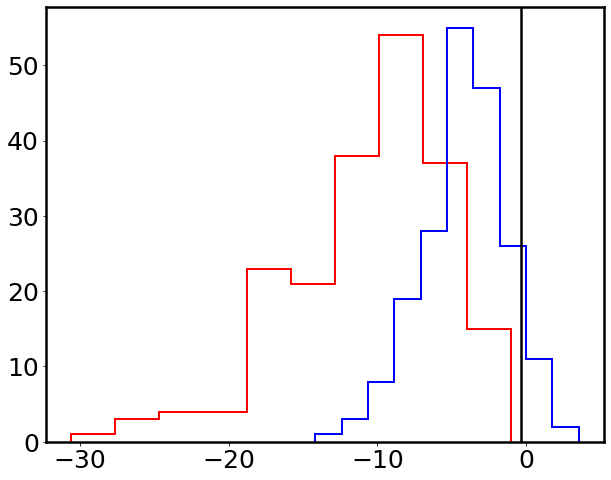

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.hist(TS_k_sb, color="r", histtype="step", lw=2.);
ax.hist(TS_bck, color="b", histtype="step", lw=2.);
ax.axvline(TS_obs, color="k", lw=2.5, ls="-")

In [68]:
from mock_generation import mock_population_all_Asimov

f         = 0.1                                                 
nBDs      = 100                                                                
sigma     = 0.3                                                                
                                              
steps     = 200 # Need to vary                                                 
                                                                               
relT = 0.1;                                                                    
ex   = "fixedT10v100"                                                   
v    = 100. # km/s                                                             
Tcut = 650. # KI                                                               
# Load ATMO2020 model                                                          
path     = "/home/mariacst/exoplanets/exoplanets/data/"                          
data     = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)         
points   = np.transpose(data[0:2, :])                                            
values   = data[2]                                                             
                                                
path = "/home/mariacst/exoplanets/exoplanets/python/data_der/"                 
#path = "/home/mariacst/exoplanets/running/v100_N1e5/data_der/"                
# Generate real observation                                                    
seed      = 250                                                                
np.random.seed(seed)                                                           
(robs, sigmarobs, Tobs, sigmaTobs, Mobs,                                      
    sigmaMobs, Aobs, sigmaAobs) = mock_population_all_Asimov(nBDs, relT,              
                                  sigma, sigma, sigma, 0., 1., 1.,             
                                  Tmin=Tcut, v=v) 

xi   = np.transpose(np.asarray([Aobs, Mobs]))                               
Teff = griddata(points, values, xi)                                         
# Load derivatives Tint wrt Age and Mass                                    
data = np.genfromtxt(path + "derivativeTint_" + ex + "_N%i_sigma%.1f_v%i.dat"
                 %(nBDs, sigma, seed), unpack=True)                         
dervTint_A = data[0]                                                        
dervTint_M = data[1] 

In [69]:
gamma_k = 1.5552

TS_obs = TS(gamma_k, f, rs_k, robs, sigmarobs, Mobs, sigmaMobs, Aobs,           
                    sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M,               
                    dervTint_A, v=v)

print(TS_obs)

0.587254134518223


In [74]:
gamma_k = 1.79286; rs_k=15.

TS_obs = TS(gamma_k, f, rs_k, robs, sigmarobs, Mobs, sigmaMobs, Aobs,           
                    sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M,               
                    dervTint_A, v=v) 

_, TS_bck = p_value_b(gamma_k, f, rs_k, nBDs, relT, sigma, sigma, sigma,                
                      points, values, TS_obs, steps=steps, Tmin=0., v=v, ex="fixedT10v100")

In [79]:
_, TS_k_s = p_value_sb(gamma_k, f, rs_k, nBDs, relT, sigma, sigma, sigma, points, values,    
                       TS_obs, steps=steps, Tmin=0., v=v, ex="fixedT10v100")

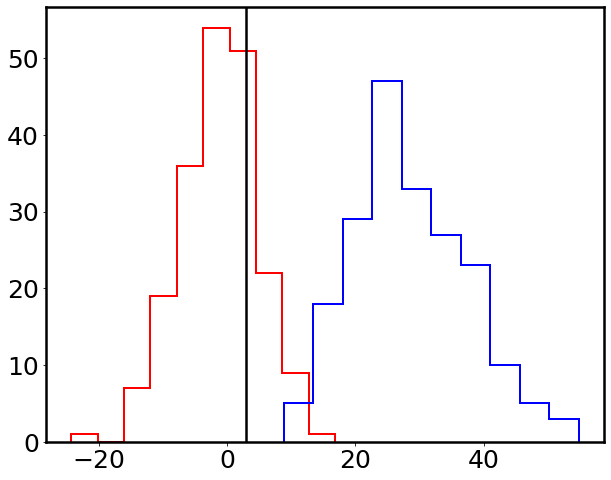

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.hist(TS_k_s, color="r", histtype="step", lw=2.);
ax.hist(TS_bck, color="b", histtype="step", lw=2.);
ax.axvline(TS_obs, color="k", lw=2.5, ls="-")

In [79]:
from mock_generation import mock_population_all_Asimov

nBDs = 100
relT = 0.1
sigma = 0.1                                                                
ex   = "fixedT10v100Tcut650"                                                
v    = 100. # km/s                                                          
Tcut = 650. # KI                                                            
# Load ATMO2020 model                                                          
path     = "/home/mariacst/exoplanets/exoplanets/data/"                     
data     = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)    
points   = np.transpose(data[0:2, :])                                       
values   = data[2]                                                                                                     
path = "/home/mariacst/exoplanets/exoplanets/python/data_der/"              
#path = "/home/mariacst/exoplanets/running/v100_N1e5/data_der/"             
# Generate real observation                                                 
seed      = 115                                                             
np.random.seed(seed)                                                        
(robs, sigmarobs, Tobs, sigmaTobs, Mobs,                                    
    sigmaMobs, Aobs, sigmaAobs) = mock_population_all(nBDs, relT,    
                                  sigma, sigma, sigma, 0., 1., 1.,          
                                  Tmin=Tcut, v=v)                           
xi   = np.transpose(np.asarray([Aobs, Mobs]))                               
Teff = griddata(points, values, xi)                                         
# Load derivatives Tint wrt Age and Mass                                    
data = np.genfromtxt(path + "derivativeTint_" + ex + "_N%i_sigma%.1f_v%i.dat"
                 %(nBDs, sigma, seed), unpack=True)                         
dervTint_A = data[0]                                                        
dervTint_M = data[1] 

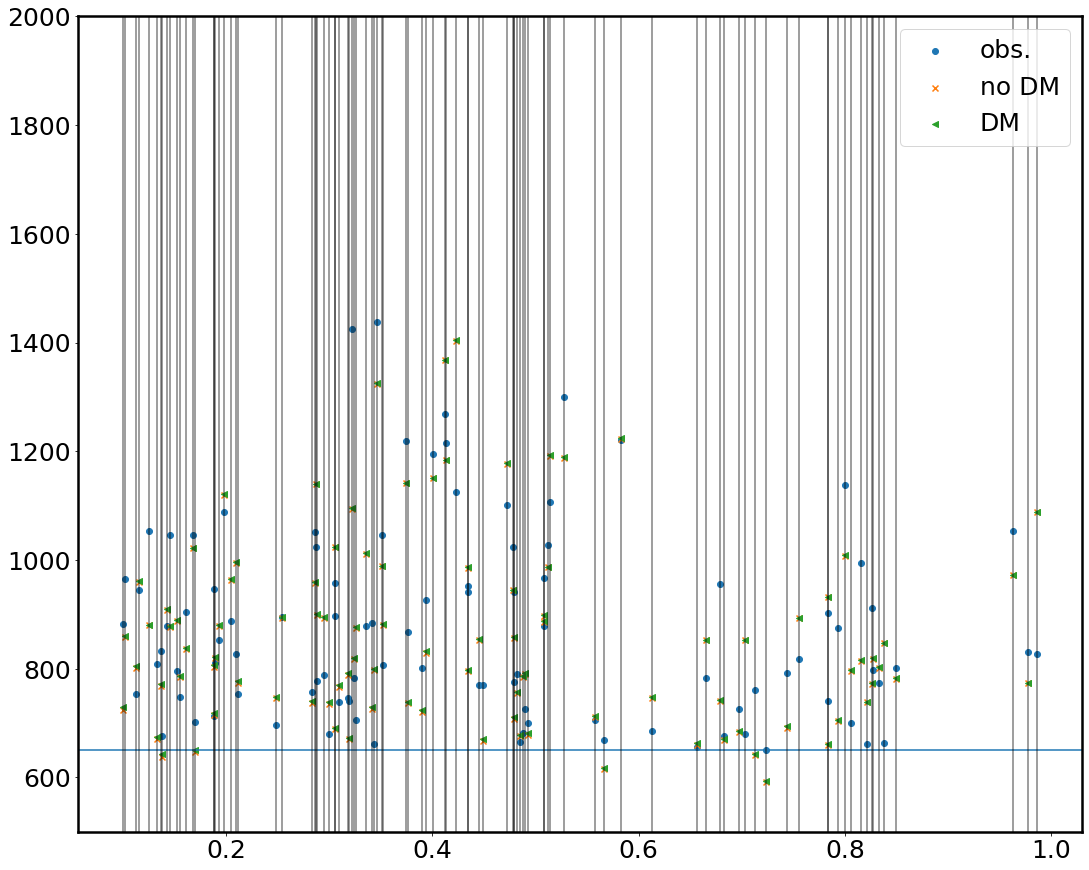

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(18, 15))
ax.scatter(robs, Tobs, label="obs.")
ax.scatter(robs, Teff, label="no DM", marker="x")

Tmodel = temperature_withDM(robs, Teff, M=Mobs*conv_Msun_to_kg, f=1.,        
                           p=[gamma_k, rs_k, 0.42], v=100.) 
ax.scatter(robs, Tmodel, label="DM", marker="<")
ax.set_ylim(500, 2000)
ax.axhline(650.)
ax.legend()

for r in robs:
    ax.axvline(r, ls="-", color="k", alpha=0.5)

In [78]:
gamma_k = 0.4; rs_k = 30.

TS_k_obs = TS(gamma_k, 1., rs_k, robs, sigmarobs, Mobs, sigmaMobs, Aobs,           
              sigmaAobs, Tobs, sigmaTobs, Teff, dervTint_M,               
              dervTint_A, v=100.) 

print(TS_k_obs)

-0.5293022616940988


In [31]:
#path    = "../python/data_UL/checkTcut/"
path = "../python/"
TS_k_b  = np.genfromtxt(path + "TS_b_fixedT10v100Tcut650_nBDs100_f1.0_steps200_sigma0.1_gamma%.5frs%.1f.dat"%(gamma_k, rs_k), unpack="True")
TS_k_sb = np.genfromtxt(path + "TS_sb_fixedT10v100Tcut650_nBDs100_f1.0_steps200_sigma0.10000_gamma%.4frs%.1f.dat"%(gamma_k, rs_k), unpack="True")

from scipy.stats import percentileofscore 
p_b  = 100-percentileofscore(TS_k_b, TS_k_obs, kind="strict")
p_sb = 100-percentileofscore(TS_k_sb, TS_k_obs, kind="strict")
print(p_b, p_sb)

CL = p_sb/p_b
print(CL, CL < 0.05)

1.5 0.0
0.0 True


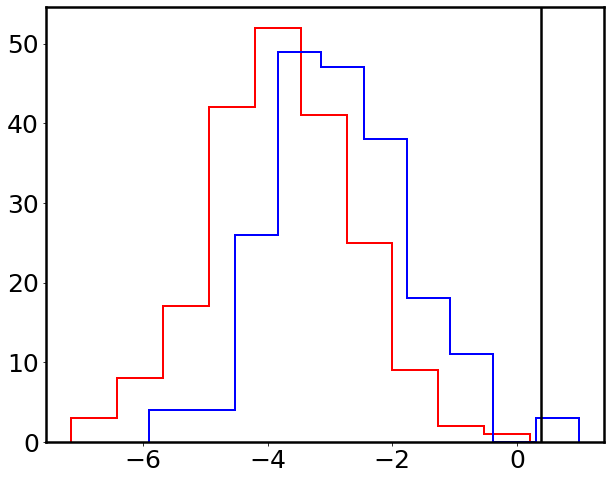

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.hist(TS_k_sb, color="r", histtype="step", lw=2.);
ax.hist(TS_k_b, color="b", histtype="step", lw=2.);
ax.axvline(TS_k_obs, color="k", lw=2.5, ls="-")

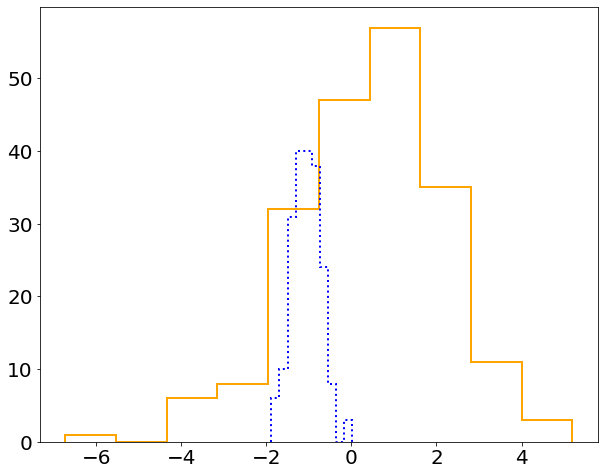

In [13]:
path    = "../python/"
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

from scipy.stats import percentileofscore

gamma_k=0.4; rs_k=30.
TS_k_sb  = np.genfromtxt(path + "TS_sb_fixedT10v100Tcut650_nBDs100_f1.0_steps400_sigma0.1_gamma%.1frs%.1f_screen.dat"%(gamma_k, rs_k), unpack="True")
ax.hist(TS_k_sb[0:200], color="orange", histtype="step", lw=2.);
#print(100-percentileofscore(TS_k_b, TS_k_obs, kind="strict"))

TS_k_sb  = np.genfromtxt(path + "TS_sb_fixedT10v100Tcut650_nBDs100_f1.0_steps200_sigma0.1_gamma%.1frs%.1f_screen.dat"%(gamma_k, rs_k), unpack="True")
ax.hist(TS_k_sb, color="b", histtype="step", lw=2., ls=":");
#ax.axvline(TS_k_obs, color="k", lw=2.5, ls="-")
#print(100-percentileofscore(TS_k_b, TS_k_obs, kind="strict"))

# OLD PART FROM HERE

Coarser vs finer grid in $\gamma$

missing 57
missing 67
missing 86
missing 89
missing 100


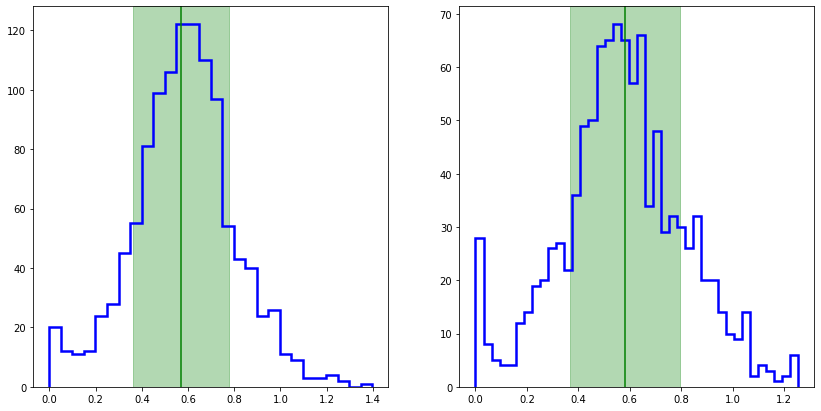

In [2]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 300 
 
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+100+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        continue
        #print("coarser, missing", i+1)
_, bins, _ = ax[0].hist(gamma_up, bins=28, histtype="step", lw=2.5, color="blue", label="coarser grid")
ax[0].axvline(np.median(gamma_up), color="green")
ax[0].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)


gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+200+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        #continue
        print("missing", i+1)
_, bins, _ = ax[1].hist(gamma_up, bins=40, histtype="step", lw=2.5, color="blue", label="finer grid")
ax[1].axvline(np.median(gamma_up), color="green")
ax[1].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)

Number of steps in the calculation of the TS' pdf

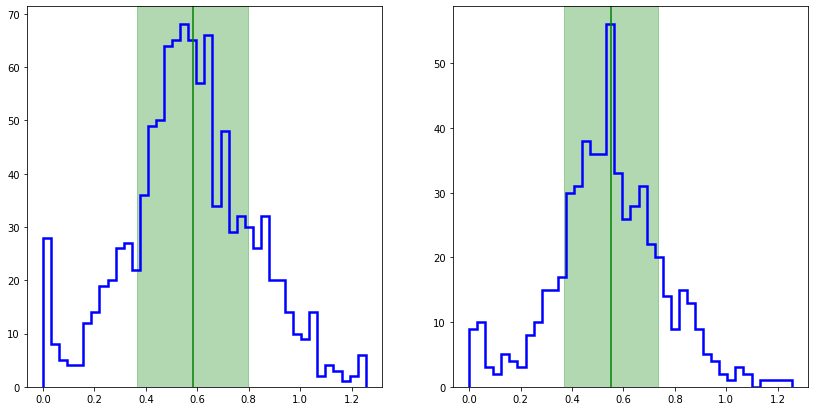

In [15]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 300
bins=40

    
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+200+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        continue
        print("missing", i+1)
_, bins, _ = ax[0].hist(gamma_up, bins=bins, histtype="step", lw=2.5, color="blue", label="300")
ax[0].axvline(np.median(gamma_up), color="green")
ax[0].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)

steps    = 500
gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+200+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        continue
        print("missing", i+1)
_, bins, _ = ax[1].hist(gamma_up, bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1].axvline(np.median(gamma_up), color="green")
ax[1].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)

missing 42
missing 53
missing 86


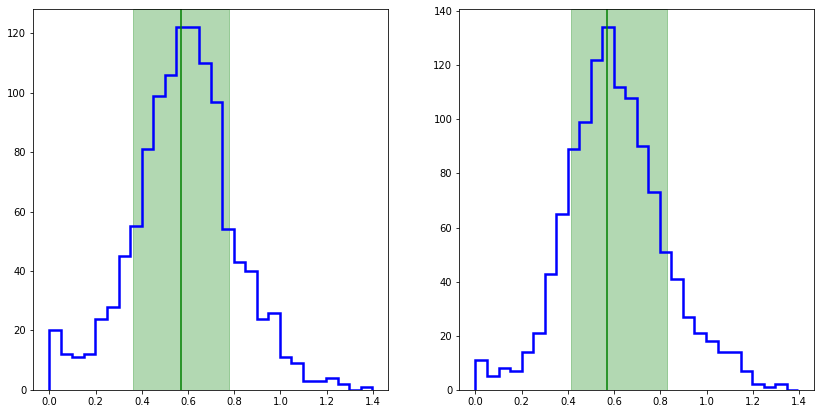

In [54]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 300
bins=28

    
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+100+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        print("missing", i+1)
_, bins, _ = ax[0].hist(gamma_up, bins=bins, histtype="step", lw=2.5, color="blue", label="300")
ax[0].axvline(np.median(gamma_up), color="green")
ax[0].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)

steps    = 500
gamma_up = np.array([])  
for i in range(100):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_rs5.0_{}_steps{}.dat".format(i+100+1, steps))
        gamma_up = np.concatenate((gamma_up, _a), axis=None)
    except:
        print("missing", i+1)
_, bins, _ = ax[1].hist(gamma_up, bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1].axvline(np.median(gamma_up), color="green")
ax[1].axvspan(np.percentile(gamma_up, 16), np.percentile(gamma_up, 84), color="g", alpha=0.3)

In [32]:
# Generate "real" observation assuming only background (no DM)
nBDs=100; relT_R=0.10; relM_R=0.10; relR_R=0.10; relA_R=0.10
rho0=0.42
# Load ATMO2020 model
path   = "/home/mariacst/exoplanets/exoplanets/data/"
data   = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]
np.random.seed(42) # ========= reproducable results!
robs_R, Tobs_R, Mobs_R, ages_R = mock_population_all(nBDs, relT_R, relM_R, 
                                     relR_R, relA_R,
                                     0, 1., 1., rho0_true=rho0, v=None)

xi         = np.transpose(np.asarray([ages_R, Mobs_R]))
Teff       = griddata(points, values, xi)
heat_int_R = heat(Teff, np.ones(len(Teff))*R_jup.value)

In [40]:
# observed
f = 1.; rs = 5.
gamma = np.linspace(0., 2., 30)
q_obs = []
for g in gamma:
    q_obs.append(TS(g, f, rs, Tobs_R, robs_R, Mobs_R, heat_int_R, relT_R))
    
    
# expected bckg
np.random.seed(2)
robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R, 0, 1., 1., 
                                             rho0_true=rho0, v=None)

xi       = np.transpose(np.asarray([ages, Mobs]))
Teff     = griddata(points, values, xi)
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

q_bck = []
for g in gamma:
    q_bck.append(TS(g, f, rs, Tobs, robs, Mobs, heat_int, relT_R))

    
    
# expected bckg
np.random.seed(7)
robs, Tobs, Mobs, ages = mock_population_all(nBDs, relT_R, relM_R, relR_R, relA_R, f, 1., 5., 
                                             rho0_true=rho0, v=None)

xi       = np.transpose(np.asarray([ages, Mobs]))
Teff     = griddata(points, values, xi)
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

q_sb = []
for g in gamma:
    q_sb.append(TS(g, f, rs, Tobs, robs, Mobs, heat_int, relT_R))

Text(0, 0.5, 'TS')

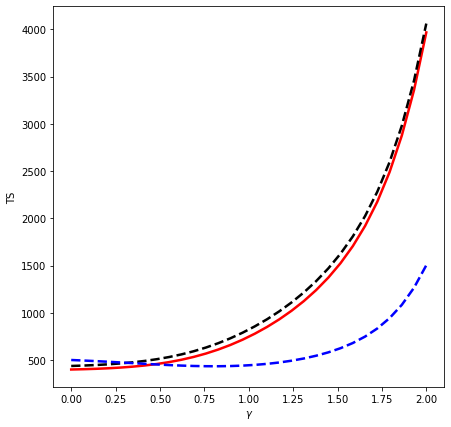

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.plot(gamma, q_obs, color="r", lw=2.5, label="observed")
ax.plot(gamma, q_bck, color="k", lw=2.5, ls="--", label="Expected background")
ax.plot(gamma, q_sb, color="blue", lw=2.5, ls="--", label=r"Expected s($\gamma=1$) + b") # creo que esta mal!
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel("TS")

In [3]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 200 
rs       = [5., 10., 15., 20.]
f        = 0.1

gamma_up_01 = np.genfromtxt(_path + "UL_f{}_{}_steps{}.dat".format(f, 2, steps)) 
gamma_up_01.shape
for i in range(350):
    try:
        _a       = np.genfromtxt(_path + "UL_f{}_{}_steps{}.dat".format(f, i+3, steps))
        gamma_up_01 = np.vstack((gamma_up_01, _a))
        #print(_a.shape, gamma_up.shape, gamma_up[:, 0].shape)
    except:
        print("coarser, missing", i+2)

coarser, missing 19
coarser, missing 20
coarser, missing 21
coarser, missing 23
coarser, missing 31
coarser, missing 32
coarser, missing 33
coarser, missing 34
coarser, missing 35
coarser, missing 36
coarser, missing 37
coarser, missing 38
coarser, missing 39
coarser, missing 40
coarser, missing 43
coarser, missing 44
coarser, missing 45
coarser, missing 64
coarser, missing 76
coarser, missing 85
coarser, missing 86
coarser, missing 88
coarser, missing 89
coarser, missing 90
coarser, missing 91
coarser, missing 93
coarser, missing 99
coarser, missing 111
coarser, missing 116
coarser, missing 118
coarser, missing 119
coarser, missing 124
coarser, missing 125
coarser, missing 126
coarser, missing 127
coarser, missing 128
coarser, missing 131
coarser, missing 134
coarser, missing 135
coarser, missing 144
coarser, missing 145
coarser, missing 146
coarser, missing 174
coarser, missing 175
coarser, missing 176
coarser, missing 177
coarser, missing 178
coarser, missing 179
coarser, missing 18

In [4]:
print(gamma_up_01.shape)

(730, 4)


In [5]:
_path    = "/home/mariacst/exoplanets/exoplanets/python/UL/"
steps    = 200 
rs       = [5., 10., 15., 20.]

gamma_up = np.genfromtxt(_path + "UL_f1.0_{}_steps{}.dat".format(1, steps)) 
gamma_up.shape
for i in range(350):
    try:
        _a       = np.genfromtxt(_path + "UL_f1.0_{}_steps{}.dat".format(i+2, steps))
        gamma_up = np.vstack((gamma_up, _a))
        #print(_a.shape, gamma_up.shape, gamma_up[:, 0].shape)
    except:
        print("coarser, missing", i+2)

coarser, missing 15
coarser, missing 16
coarser, missing 351


In [6]:
print(gamma_up.shape)
print(np.median(gamma_up, axis=0))

(2230, 4)
[0.5735 0.8412 0.9882 1.0618]


Text(0.5, 0, '$r_s$ [kpc]')

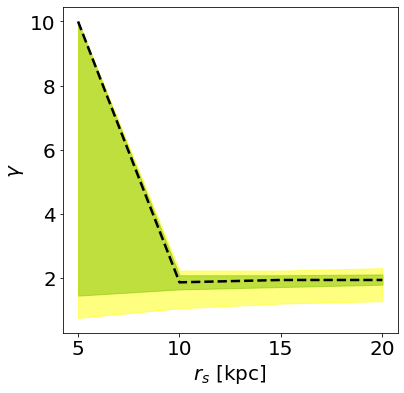

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(rs, np.median(gamma_up_01, axis=0), color="k", lw=2.5, ls="--")
ax.fill_between(rs, np.percentile(gamma_up_01, 16, axis=0), np.percentile(gamma_up_01, 84, axis=0), 
                color="green", alpha=0.5)

ax.fill_between(rs, np.percentile(gamma_up_01, 2.5, axis=0), np.percentile(gamma_up_01, 97.5, axis=0), 
                color="yellow", alpha=0.5)

ax.set_ylabel(r"$\gamma$")
ax.set_xlabel("$r_s$ [kpc]")

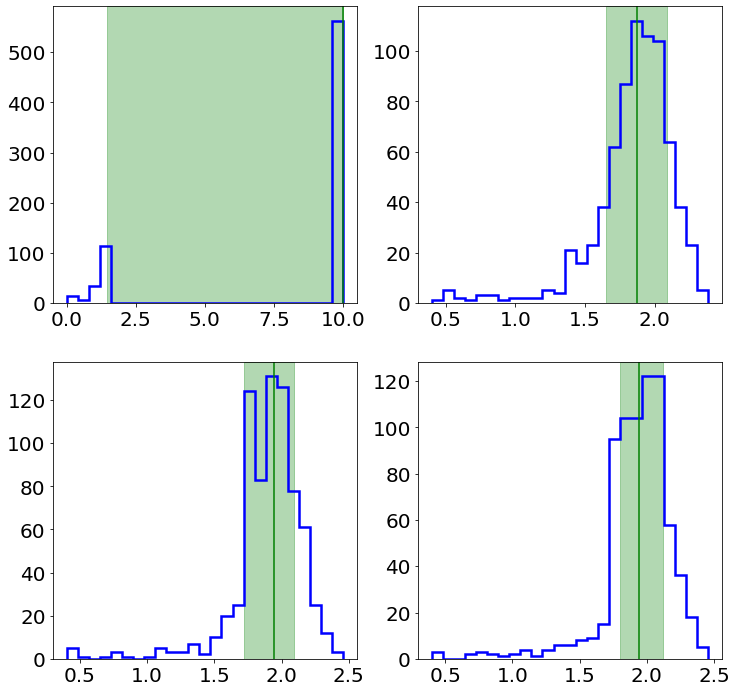

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

bins=25

_, _, _ = ax[0, 0].hist(gamma_up_01[:, 0], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[0, 0].axvline(np.median(gamma_up_01[:, 0]), color="green")
ax[0, 0].axvspan(np.percentile(gamma_up_01[:, 0], 16), np.percentile(gamma_up_01[:, 0], 84), color="g", alpha=0.3)

_, _, _ = ax[0, 1].hist(gamma_up_01[:, 1], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[0, 1].axvline(np.median(gamma_up_01[:, 1]), color="green")
ax[0, 1].axvspan(np.percentile(gamma_up_01[:, 1], 16), np.percentile(gamma_up_01[:, 1], 84), color="g", alpha=0.3)

_, _, _ = ax[1, 0].hist(gamma_up_01[:, 2], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1, 0].axvline(np.median(gamma_up_01[:, 2]), color="green")
ax[1, 0].axvspan(np.percentile(gamma_up_01[:, 2], 16), np.percentile(gamma_up_01[:, 2], 84), color="g", alpha=0.3)

_, _, _ = ax[1, 1].hist(gamma_up_01[:, 3], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1, 1].axvline(np.median(gamma_up_01[:, 3]), color="green")
ax[1, 1].axvspan(np.percentile(gamma_up_01[:, 3], 16), np.percentile(gamma_up_01[:, 3], 84), color="g", alpha=0.3)

Text(0.5, 0, '$r_s$ [kpc]')

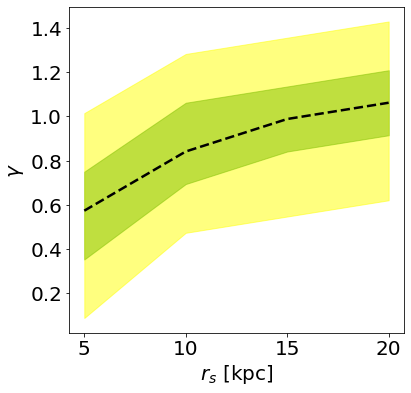

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(rs, np.median(gamma_up, axis=0), color="k", lw=2.5, ls="--")
ax.fill_between(rs, np.percentile(gamma_up, 16, axis=0), np.percentile(gamma_up, 84, axis=0), 
                color="green", alpha=0.5)

ax.fill_between(rs, np.percentile(gamma_up, 2.5, axis=0), np.percentile(gamma_up, 97.5, axis=0), 
                color="yellow", alpha=0.5)

ax.set_ylabel(r"$\gamma$")
ax.set_xlabel("$r_s$ [kpc]")

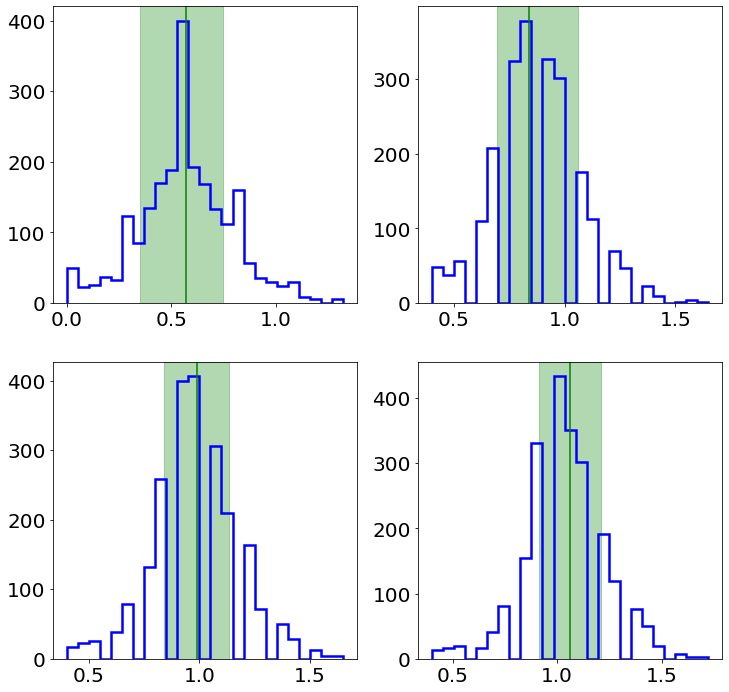

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

bins=25

_, _, _ = ax[0, 0].hist(gamma_up[:, 0], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[0, 0].axvline(np.median(gamma_up[:, 0]), color="green")
ax[0, 0].axvspan(np.percentile(gamma_up[:, 0], 16), np.percentile(gamma_up[:, 0], 84), color="g", alpha=0.3)

_, _, _ = ax[0, 1].hist(gamma_up[:, 1], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[0, 1].axvline(np.median(gamma_up[:, 1]), color="green")
ax[0, 1].axvspan(np.percentile(gamma_up[:, 1], 16), np.percentile(gamma_up[:, 1], 84), color="g", alpha=0.3)

_, _, _ = ax[1, 0].hist(gamma_up[:, 2], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1, 0].axvline(np.median(gamma_up[:, 2]), color="green")
ax[1, 0].axvspan(np.percentile(gamma_up[:, 2], 16), np.percentile(gamma_up[:, 2], 84), color="g", alpha=0.3)

_, _, _ = ax[1, 1].hist(gamma_up[:, 3], bins=bins, histtype="step", lw=2.5, color="blue", label="500")
ax[1, 1].axvline(np.median(gamma_up[:, 3]), color="green")
ax[1, 1].axvspan(np.percentile(gamma_up[:, 3], 16), np.percentile(gamma_up[:, 3], 84), color="g", alpha=0.3)

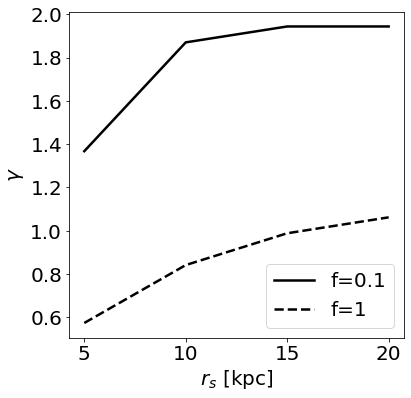

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

pos = np.where(gamma_up_01[:, 0] < 5)

med = [np.median(gamma_up_01[:, 0][pos])]
for i in range(3):
    med.append(np.median(gamma_up_01[:, i+1]))

#ax.plot(rs, np.median(gamma_up_01, axis=0), color="k", lw=2.5, ls="-")
ax.plot(rs, med, color="k", lw=2.5, ls="-", label="f=0.1")
#ax.fill_between(rs, np.percentile(gamma_up_01, 16, axis=0), np.percentile(gamma_up_01, 84, axis=0), 
#                color="green", alpha=0.5)

ax.plot(rs, np.median(gamma_up, axis=0), color="k", lw=2.5, ls="--", label="f=1")
#ax.fill_between(rs, np.percentile(gamma_up, 16, axis=0), np.percentile(gamma_up, 84, axis=0), 
#                color="green", alpha=0.5)

ax.legend()
ax.set_ylabel(r"$\gamma$")
ax.set_xlabel("$r_s$ [kpc]")

#fig.savefig("/home/mariacst/exoplanets/Figs/exclusion_limit_DM_shape.pdf", bbox_inches="tight")

Text(0.5, 0, '$r_s$ [kpc]')

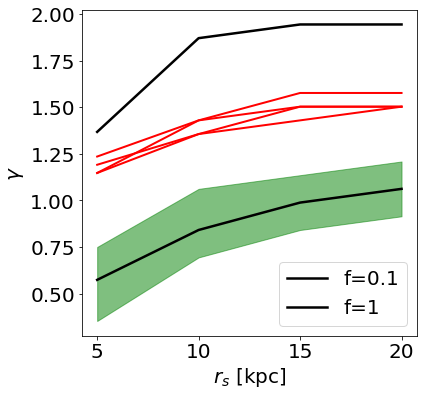

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

files = ["UL_f1.0_Asimov42_steps200.dat", "UL_f1.0_Asimov42_steps500.dat", "UL_f1.0_Asimov_steps200.dat", 
         "UL_f1.0_Asimov_steps500.dat"]

for f in files:
    data = np.genfromtxt("/home/mariacst/exoplanets/exoplanets/python/UL/" + f, unpack=True)
    ax.plot(rs, data, color="r", lw=2.)
    
pos = np.where(gamma_up_01[:, 0] < 5)

med = [np.median(gamma_up_01[:, 0][pos])]
for i in range(3):
    med.append(np.median(gamma_up_01[:, i+1]))

#ax.plot(rs, np.median(gamma_up_01, axis=0), color="k", lw=2.5, ls="-")
ax.plot(rs, med, color="k", lw=2.5, ls="-", label="f=0.1")
#ax.fill_between(rs, np.percentile(gamma_up_01, 16, axis=0), np.percentile(gamma_up_01, 84, axis=0), 
#                color="green", alpha=0.5)

ax.plot(rs, np.median(gamma_up, axis=0), color="k", lw=2.5, ls="-", label="f=1")
ax.fill_between(rs, np.percentile(gamma_up, 16, axis=0), np.percentile(gamma_up, 84, axis=0), 
                color="green", alpha=0.5)

ax.legend()
ax.set_ylabel(r"$\gamma$")
ax.set_xlabel("$r_s$ [kpc]")

In [37]:
_file = open("/home/mariacst/exoplanets/exoplanets/python/likelihood_Asimov_N100_relunc0.00_relM0.00_f1.0gamma1.0rs10.0v1", "rb") 
like  = pickle.load(_file)

_file    = open("/home/mariacst/exoplanets/exoplanets/python/posterior_Asimov_N100_relunc0.00_relM0.00_f1.0gamma1.0rs10.0v1", "rb") 
samples  = pickle.load(_file)

print(like.shape, samples.shape)

(250000,) (250000, 3)


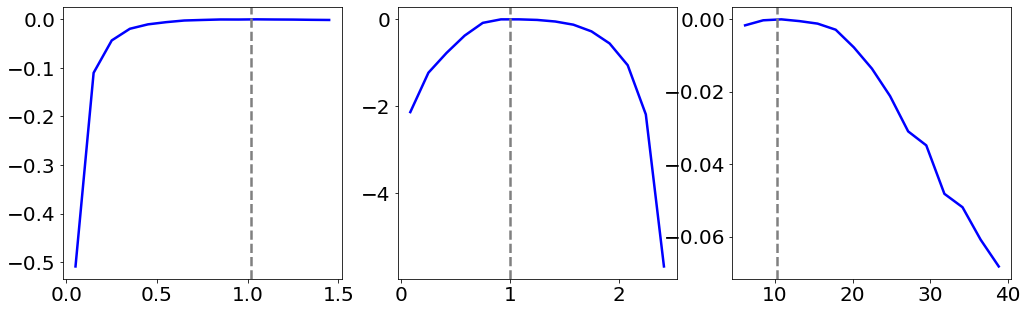

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

def like_1D(bins, p):
    _like  = []
    x_like = []
    for i in range(len(bins)-1):
        pos = np.where((samples[:, p] >= bins[i]) & (samples[:, p]<= bins[i+1]))
        _like.append(np.max(like[pos]))
        x_like.append(0.5*(bins[i] + bins[i+1]))
    return x_like, _like

def maxlike(L, samples, column):
    """
    find max L profile solutions
    """
    max_    = samples[:,column][np.argmax(L)]
    return max_

bins = np.linspace(0., 1.5, 16)
x_f, like_f = like_1D(bins, 0)
ax[0].plot(x_f, like_f, color="blue", lw=2.5)
ax[0].axvline(maxlike(like, samples, 0), color="grey", ls="--", lw=2.5)

bins = np.linspace(0., 2.5, 16)
x_g, like_g = like_1D(bins, 1)
ax[1].plot(x_g, like_g, color="blue", lw=2.5)
ax[1].axvline(maxlike(like, samples, 1), color="grey", ls="--", lw=2.5)

bins = np.linspace(5., 40., 16)
x_rs, like_rs = like_1D(bins, 2)
ax[2].plot(x_rs, like_rs, color="blue", lw=2.5)
ax[2].axvline(maxlike(like, samples, 2), color="grey", ls="--", lw=2.5)

Text(0.5, 0, '$r_s$ [kpc]')

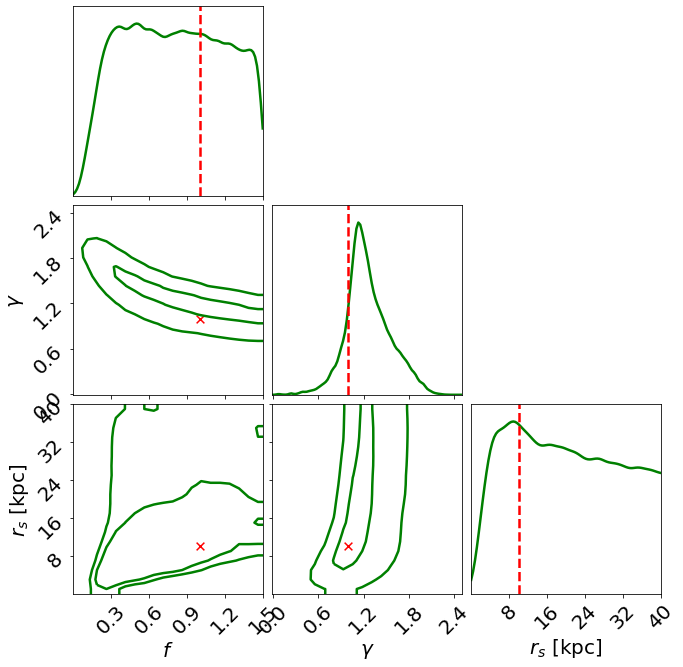

In [45]:
import pickle
from _corner import corner
from scipy.stats import gaussian_kde

nBDs     = 100
relT     = 0.10
relM     = 0.10
f        = 1.
gamma    = 1.
rs       = 10.

smooth=1.
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth, color="green",
                   range=[(0., 1.5), (-0.01, 2.5), (0., 40.)])
# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="green", lw=2.5)       
    
axes[0, 0].axvline(1., color="r", ls="--", lw=2.5)
axes[1, 1].axvline(gamma, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(rs, color="r", ls="--", lw=2.5)
axes[1, 0].scatter(f, gamma, marker="x", color="red", s=60)
axes[2, 0].scatter(f, rs, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma, rs, marker="x", color="red", s=60)
    
axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")